In [4]:
import yfinance as yf
import pandas as pd
def fetch_yfinance_data(tickers: list[str], period="1mo", interval="1d") -> pd.DataFrame:
        df = yf.download(tickers, period=period, interval=interval, group_by='ticker', auto_adjust=False)
        flat_df = (
            df.stack(level=0, future_stack=True)
            .reset_index()
            .rename(columns={
                "Date": "date",
                "Open": "open",
                "High": "high",
                "Low": "low",
                "Close": "close",
                "Volume": "volume",
                "Ticker": "ticker"
            })[["date", "ticker", "open", "high", "low", "close", "volume"]]
        )
        return flat_df

In [48]:
TICKERS = [
    "AAPL", "TSLA", "AMZN", "MSFT", "NVDA",
    "GME", "AMC", "META","JPM", "SPY",
    "UNH", "C"
]
df = fetch_yfinance_data(TICKERS, period="1mo", interval="1d")

[*********************100%***********************]  12 of 12 completed


In [49]:
def interpolate_group(x):
    x = x.infer_objects()
    # Convert 'close' to numeric (float), in case it's still object dtype
    x['close'] = pd.to_numeric(x['close'], errors='coerce')
    return x.interpolate()

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])
print(df.columns)
df1 = df.groupby('ticker').apply(interpolate_group).reset_index(drop=True)
print(df1.columns)

df1['returns'] = df1.groupby('ticker')['close'].pct_change()
q_low = df1['returns'].quantile(0.01)
q_high = df1['returns'].quantile(0.99)
df2 = df1[(df1['returns'] > q_low) & (df1['returns'] < q_high)]

Index(['date', 'ticker', 'open', 'high', 'low', 'close', 'volume'], dtype='object', name='Price')
Index(['date', 'ticker', 'open', 'high', 'low', 'close', 'volume'], dtype='object', name='Price')


/var/folders/y9/m6kzn12n3yn2h7b76mwm3zv40000gn/T/ipykernel_64233/1046565517.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return x.interpolate()
/var/folders/y9/m6kzn12n3yn2h7b76mwm3zv40000gn/T/ipykernel_64233/1046565517.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return x.interpolate()
/var/folders/y9/m6kzn12n3yn2h7b76mwm3zv40000gn/T/ipykernel_64233/1046565517.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return x.interpolate()
/var/folders/y9/m6kzn12n3yn2h7b76mwm3zv40000gn/T/ipykernel_64233/1046565517.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in 

In [50]:
df2

Price,date,ticker,open,high,low,close,volume,returns
1,2025-05-01,AAPL,209.080002,214.559998,208.899994,213.320007,57365700,0.003859
2,2025-05-02,AAPL,206.089996,206.990005,202.160004,205.350006,101010600,-0.037362
3,2025-05-05,AAPL,203.100006,204.100006,198.210007,198.889999,69018500,-0.031459
4,2025-05-06,AAPL,198.210007,200.649994,197.020004,198.509995,51216500,-0.001911
5,2025-05-07,AAPL,199.169998,199.440002,193.250000,196.250000,68536700,-0.011385
...,...,...,...,...,...,...,...,...
259,2025-05-23,UNH,296.100006,299.700012,291.640015,295.570007,16873600,-0.003708
260,2025-05-27,UNH,299.500000,299.950012,289.130005,295.000000,20144600,-0.001929
261,2025-05-28,UNH,294.000000,303.779999,293.279999,298.109985,16114200,0.010542
262,2025-05-29,UNH,296.799988,303.380005,295.000000,298.170013,16221100,0.000201


In [51]:
df2['ticker'].value_counts()

ticker
AAPL    21
AMZN    21
C       21
JPM     21
META    21
MSFT    21
NVDA    21
SPY     21
TSLA    21
GME     20
UNH     19
AMC     18
Name: count, dtype: int64

In [53]:
import requests
def fetch_financelayer_news(keywords, limit=100):
    url = "https://api.apilayer.com/financelayer/news"
    headers = {"apikey": "test"}
    params = {
        "keywords": ",".join(keywords),
        "dateFrom": "2025-05-01",
        "dateTo": "2025-05-02",
        "limit": limit
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    articles = data.get("data", [])
    df = pd.DataFrame(articles)
    return df

In [54]:
df3 = fetch_financelayer_news(TICKERS, limit=100)

In [55]:
import re
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

def preprocess_reddit(df: pd.DataFrame) -> pd.DataFrame:
    df['cleaned_text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')
    df['cleaned_text'] = df['cleaned_text'].apply(clean_text)
    return df

def preprocess_financelayer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates(subset=['title', 'published_at'])
    df = df.dropna(subset=['title', 'description'])
    df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
    df['cleaned_text'] = df['title'].fillna('') + ' ' + df['description'].fillna('')
    df['cleaned_text'] = df['cleaned_text'].apply(clean_text)
    return df

In [56]:
df4 = preprocess_financelayer(df3)

In [57]:
df4

,title,url,description,source,tickers,tags,published_at,cleaned_text
0,"Magnificent 7 Earnings: What to Expect (AMZN, ...",https://www.zacks.com/commentary/2459147/magni...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,"[aapl, amzn, meta, meta, metv, msft]","[Consumer Cyclical, ETF, Investment Ideas, Sto...",2025-04-30 14:35:00+00:00,magnificent 7 earnings expect amzn aapl meta m...
1,"SA analyst upgrades: TSLA, AAPL, NVDA, META, P...",https://seekingalpha.com/news/4430194-sa-analy...,Seeking Alpha analysts issue upgrades for TSLA...,seekingalpha.com,[],[],2025-04-10 16:09:50+00:00,sa analyst upgrades tsla aapl nvda meta pltr a...
2,"Earnings week ahead: MSFT, AAPL, META, AMZN, Q...",https://seekingalpha.com/news/4435596-earnings...,Get ready for a pivotal week in the market as ...,seekingalpha.com,[],[],2025-04-27 12:03:33+00:00,earnings week ahead msft aapl meta amzn qcom p...
3,"SA Analyst Rating Downgrades: MSFT, TSLA, NVDA...",https://seekingalpha.com/news/4429498-sa-analy...,Seeking Alpha analysts have issued downgrades ...,seekingalpha.com,"[msft, nvda]","[Stock, Technology]",2025-04-08 16:38:42+00:00,sa analyst rating downgrades msft tsla nvda ii...
4,"Appaloosa trims AMZN, MSFT, QCOM, and adds to ...",https://seekingalpha.com/news/4449323-appaloos...,Discover Appaloosa Management's position moves...,seekingalpha.com,[],[],2025-05-15 23:50:02+00:00,appaloosa trims amzn msft qcom adds nrg glw un...
...,...,...,...,...,...,...,...,...
95,Nvidia (NVDA) Moves 18.7% Higher: Will This St...,https://www.zacks.com/stock/news/2443106/nvidi...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,"[intc, nvda]","[Stock, Tale Of The Tape, Technology]",2025-04-10 12:30:00+00:00,nvidia nvda moves 187 higher strength last par...
96,UnitedHealth unit to cut up to 25% of reauthor...,https://seekingalpha.com/news/4422199-unitedhe...,UnitedHealth's (UNH) Optum Rx simplifies acces...,seekingalpha.com,[unh],"[Healthcare, Stock]",2025-03-19 14:14:59+00:00,unitedhealth unit cut 25 reauthorizations unh ...
97,"Compared to Estimates, AMC Entertainment (AMC)...",https://www.zacks.com/stock/news/2464755/compa...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,[amc],"[Consumer Cyclical, Fundamental Analysis, Stock]",2025-05-08 00:00:06+00:00,compared estimates amc entertainment amc q1 ea...
98,GameStop (GME) Stock Moves -0.04%: What You Sh...,https://www.zacks.com/stock/news/2452169/games...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,[gme],"[Consumer Cyclical, Stock, Tale Of The Tape]",2025-04-21 21:45:32+00:00,gamestop gme stock moves 004 know pardon inter...


In [58]:
df4.tickers.value_counts()

tickers
[gme]                                                  17
[]                                                     16
[msft]                                                  5
[aaic, ai, msft]                                        4
[nvda]                                                  4
[unh]                                                   4
[aapl, msft]                                            3
[tsla]                                                  2
[amc]                                                   2
[aapl, meta, msft]                                      2
[aapl, amzn, meta, meta, metv, msft]                    2
[aapl]                                                  2
[msft, nvda]                                            2
[avxl, nvda]                                            1
[msft, unh]                                             1
[meta, meta, metv]                                      1
[nvda, zs]                                              1
[amc, 

In [59]:
df4.tags.value_counts()

tags
[Consumer Cyclical, Stock, Tale Of The Tape]                                                                                                                         14
[]                                                                                                                                                                   11
[Stock, Tale Of The Tape, Technology]                                                                                                                                 6
[Stock, Stockstory, Technology, Tiingo Top, Why-It-Moves-Single]                                                                                                      5
[Consumer Cyclical, Stock]                                                                                                                                            5
[Stock, Technology]                                                                                                                                        

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

print(model.config.id2label)
print(model.config.num_labels)

LABELS = model.config.id2label

def finbert_predict_sentiment(text: str):
    """
    Returns (sentiment_label, [prob_negative, prob_neutral, prob_positive])
    """
    if not isinstance(text, str) or not text.strip():
        return "neutral", [0.0, 1.0, 0.0]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).squeeze().tolist()
        label_id = int(torch.argmax(outputs.logits, dim=1))
        return LABELS[label_id], probs

def add_finbert_sentiment(df: pd.DataFrame, text_col: str, prefix: str = "sentiment"):
    # Get sentiment results
    results = df[text_col].astype(str).apply(finbert_predict_sentiment)
    # Extract labels and probabilities
    df = df.reset_index(drop=True)
    labels = results.apply(lambda x: x[0])
    probs = results.apply(lambda x: x[1]).tolist()
    probs_df = pd.DataFrame(probs, columns=[f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"])
    probs_df = probs_df.reset_index(drop=True)
    # Assign columns
    df[f"{prefix}_label"] = labels.values
    df[[f"{prefix}_neg", f"{prefix}_neu", f"{prefix}_pos"]] = probs_df
    df[f"{prefix}_score"] = df[f"{prefix}_pos"] - df[f"{prefix}_neg"]
    return df



/Users/oindreelabhowmick/Documents/WILP/Sem4/dissertation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{0: 'positive', 1: 'negative', 2: 'neutral'}
3


In [1]:
import pandas as pd
reddit_df = pd.read_csv("../data/raw/reddit_posts.csv")
news_df = pd.read_csv("../data/raw/finance_news.csv")

In [2]:
reddit_df

,id,created_utc,title,selftext,score,upvote_ratio,num_comments,total_awards_received,author,subreddit,mentioned_tickers,cleaned_text
0,1l5o7oz,2025-06-07 16:00:35+00:00,r/Stocks Weekly Thread on Meme Stocks Saturday...,The meme stock scheduled posts will now run we...,1,1.00,0,0,AutoModerator,stocks,"['GME', 'C']",rstocks weekly thread meme stocks saturday jun...
1,1l5mw0h,2025-06-07 15:03:11+00:00,My Thesis on TSLA ($295.14) and CRWV ($140.16),"***This is a multi-signal analysis***, built b...",0,0.27,15,0,retroviber,stocks,"['TSLA', 'C']",thesis tsla 29514 crwv 14016 multisignal analy...
2,1l5muv2,2025-06-07 15:01:49+00:00,Federal Reserve lifts $1.95 Trillion asset cap...,"After 7 years, Wells Fargo is finally able to ...",149,0.95,41,0,ComposedStudent,stocks,['C'],federal reserve lifts 195 trillion asset cap w...
3,1l5ll2k,2025-06-07 14:03:50+00:00,Trump announces US - China trade talks in Lond...,"If true, this is obviously extremely bullish. ...",0,0.43,33,0,RepairmanJack2025,stocks,['C'],trump announces us china trade talks london ne...
4,1l5l6fl,2025-06-07 13:44:27+00:00,How do we feel about snack and food companies ...,"I’ve been watching HSY and HRL for awhile now,...",7,0.90,14,0,liamisabossss,stocks,['C'],feel snack food companies right hsy hrl ive wa...
...,...,...,...,...,...,...,...,...,...,...,...,...
84,1l53g4p,2025-06-06 21:04:37+00:00,$SPCE Virgin Galactic after executive order to...,The Executive Order aims to bolster the United...,5,0.86,9,0,Fine-Drummer2604,pennystocks,['C'],spce virgin galactic executive order promote s...
85,1l50hor,2025-06-06 18:59:49+00:00,"Sonic Labs ($S) is coming in hot, and Spetz In...",While most retail is still chasing Solana echo...,5,0.86,3,0,RockBottomRiches,pennystocks,['C'],sonic labs coming hot spetz inc sptzcn dbksfus...
86,1l4x6rg,2025-06-06 16:45:37+00:00,$GPOX - The initial revenue potential of 10 se...,$GPOX - The initial revenue potential of 10 se...,0,0.50,1,0,Front-Page_News,pennystocks,['C'],gpox initial revenue potential 10 seats estima...
87,1l4x46d,2025-06-06 16:42:38+00:00,Did some more digging into $INTZ,# Moving Averages (MA 10 / 50 / 200):\n\n* **1...,8,0.90,24,0,Glad_Palpitation1274,pennystocks,['C'],digging intz moving averages 10 50 200 1day pr...


In [12]:
news_df

,title,url,description,source,tickers,tags,published_at,cleaned_text
0,"Magnificent 7 Earnings: What to Expect (AMZN, ...",https://www.zacks.com/commentary/2459147/magni...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,"['aapl', 'amzn', 'meta', 'meta', 'metv', 'msft']","['Consumer Cyclical', 'ETF', 'Investment Ideas...",2025-04-30 14:35:00+00:00,magnificent 7 earnings expect amzn aapl meta m...
1,"SA analyst upgrades: TSLA, AAPL, NVDA, META, P...",https://seekingalpha.com/news/4430194-sa-analy...,Seeking Alpha analysts issue upgrades for TSLA...,seekingalpha.com,[],[],2025-04-10 16:09:50+00:00,sa analyst upgrades tsla aapl nvda meta pltr a...
2,"Earnings week ahead: MSFT, AAPL, META, AMZN, Q...",https://seekingalpha.com/news/4435596-earnings...,Get ready for a pivotal week in the market as ...,seekingalpha.com,[],[],2025-04-27 12:03:33+00:00,earnings week ahead msft aapl meta amzn qcom p...
3,"SA Analyst Rating Downgrades: MSFT, TSLA, NVDA...",https://seekingalpha.com/news/4429498-sa-analy...,Seeking Alpha analysts have issued downgrades ...,seekingalpha.com,"['msft', 'nvda']","['Stock', 'Technology']",2025-04-08 16:38:42+00:00,sa analyst rating downgrades msft tsla nvda ii...
4,"Appaloosa trims AMZN, MSFT, QCOM, and adds to ...",https://seekingalpha.com/news/4449323-appaloos...,Discover Appaloosa Management's position moves...,seekingalpha.com,[],[],2025-05-15 23:50:02+00:00,appaloosa trims amzn msft qcom adds nrg glw un...
...,...,...,...,...,...,...,...,...
95,Is Most-Watched Stock GameStop Corp. (GME) Wor...,https://www.zacks.com/stock/news/2447266/is-mo...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-04-11 13:00:12+00:00,mostwatched stock gamestop corp gme worth bett...
96,Why GameStop (GME) Dipped More Than Broader Ma...,https://www.zacks.com/stock/news/2449433/why-g...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-04-15 21:45:16+00:00,gamestop gme dipped broader market today pardo...
97,GameStop Corp. (GME) Is a Trending Stock: Fact...,https://www.zacks.com/stock/news/2477571/games...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-05-27 13:00:12+00:00,gamestop corp gme trending stock facts know be...
98,GameStop (GME) Advances While Market Declines:...,https://www.zacks.com/stock/news/2479909/games...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-05-30 21:45:04+00:00,gamestop gme advances market declines informat...


In [32]:
# For Reddit, use the relevant text column (e.g., 'cleaned_text' or 'body')
#reddit_df = add_finbert_sentiment(reddit_df, text_col="cleaned_text", prefix="reddit_sentiment")
results = reddit_df["cleaned_text"].astype(str).apply(finbert_predict_sentiment)

[0.17397724092006683, 0.26647284626960754, 0.559549868106842]
[0.03389478474855423, 0.6617810130119324, 0.30432412028312683]
[0.13427099585533142, 0.013234831392765045, 0.8524941205978394]
[0.06145898252725601, 0.17644304037094116, 0.7620980143547058]
[0.6995263695716858, 0.0180156622081995, 0.28245794773101807]
[0.02800300531089306, 0.03304717317223549, 0.9389498233795166]
[0.041855353862047195, 0.047088854014873505, 0.9110558032989502]
[0.03155525401234627, 0.06890774518251419, 0.8995370268821716]
[0.06896901875734329, 0.08122608065605164, 0.8498049378395081]
[0.04390062019228935, 0.08355899900197983, 0.8725403547286987]
[0.04586304724216461, 0.09161386638879776, 0.862523078918457]
[0.052170589566230774, 0.027865739539265633, 0.9199637174606323]
[0.02178846299648285, 0.11172299087047577, 0.866488516330719]
[0.06175318360328674, 0.03673790767788887, 0.9015089273452759]
[0.038757581263780594, 0.11092673987150192, 0.8503156304359436]
[0.03431328386068344, 0.02997387945652008, 0.93571287

In [16]:
results

0      (neutral, [0.3720245659351349, 0.6279754638671...
1      (neutral, [0.46335315704345703, 0.536646842956...
2      (neutral, [0.4640386402606964, 0.5359613895416...
3      (neutral, [0.45674532651901245, 0.543254733085...
4      (neutral, [0.3802461624145508, 0.6197538971900...
                             ...                        
108    (neutral, [0.3883647322654724, 0.6116352677345...
109    (neutral, [0.42498478293418884, 0.575015246868...
110    (neutral, [0.3568061590194702, 0.6431939005851...
111    (neutral, [0.4619097411632538, 0.5380902886390...
112    (neutral, [0.357825368642807, 0.64217466115951...
Name: cleaned_text, Length: 113, dtype: object

In [20]:
labels = results.apply(lambda x: x[0])
probs = results.apply(lambda x: x[1])

In [18]:
labels

0      neutral
1      neutral
2      neutral
3      neutral
4      neutral
        ...   
108    neutral
109    neutral
110    neutral
111    neutral
112    neutral
Name: cleaned_text, Length: 113, dtype: object

In [21]:
probs

0       [0.3720245659351349, 0.6279754638671875]
1       [0.46335315704345703, 0.536646842956543]
2        [0.4640386402606964, 0.535961389541626]
3      [0.45674532651901245, 0.5432547330856323]
4        [0.3802461624145508, 0.619753897190094]
                         ...                    
108     [0.3883647322654724, 0.6116352677345276]
109    [0.42498478293418884, 0.5750152468681335]
110     [0.3568061590194702, 0.6431939005851746]
111     [0.4619097411632538, 0.5380902886390686]
112      [0.357825368642807, 0.6421746611595154]
Name: cleaned_text, Length: 113, dtype: object

In [25]:
probs_df = pd.DataFrame(probs.tolist(), columns=[f"reddit_sentiment_neg", f"reddit_sentiment_neu", f"reddit_sentiment_pos"])

ValueError: 3 columns passed, passed data had 2 columns

In [24]:
probs_df

,reddit_sentiment_neg,reddit_sentiment_neu,reddit_sentiment_pos


In [35]:
# For FinanceLayer, use the relevant text column (e.g., 'title' or 'description')
news_df = add_finbert_sentiment(news_df, text_col="cleaned_text", prefix="news_sentiment")

In [36]:
news_df

,title,url,description,source,tickers,tags,published_at,cleaned_text,news_sentiment_label,news_sentiment_neg,news_sentiment_neu,news_sentiment_pos,news_sentiment_score
0,"Magnificent 7 Earnings: What to Expect (AMZN, ...",https://www.zacks.com/commentary/2459147/magni...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,"['aapl', 'amzn', 'meta', 'meta', 'metv', 'msft']","['Consumer Cyclical', 'ETF', 'Investment Ideas...",2025-04-30 14:35:00+00:00,magnificent 7 earnings expect amzn aapl meta m...,neutral,0.026756,0.355787,0.617457,0.590701
1,"SA analyst upgrades: TSLA, AAPL, NVDA, META, P...",https://seekingalpha.com/news/4430194-sa-analy...,Seeking Alpha analysts issue upgrades for TSLA...,seekingalpha.com,[],[],2025-04-10 16:09:50+00:00,sa analyst upgrades tsla aapl nvda meta pltr a...,neutral,0.107851,0.028337,0.863813,0.755962
2,"Earnings week ahead: MSFT, AAPL, META, AMZN, Q...",https://seekingalpha.com/news/4435596-earnings...,Get ready for a pivotal week in the market as ...,seekingalpha.com,[],[],2025-04-27 12:03:33+00:00,earnings week ahead msft aapl meta amzn qcom p...,neutral,0.087413,0.050054,0.862532,0.775119
3,"SA Analyst Rating Downgrades: MSFT, TSLA, NVDA...",https://seekingalpha.com/news/4429498-sa-analy...,Seeking Alpha analysts have issued downgrades ...,seekingalpha.com,"['msft', 'nvda']","['Stock', 'Technology']",2025-04-08 16:38:42+00:00,sa analyst rating downgrades msft tsla nvda ii...,negative,0.017167,0.795692,0.187141,0.169974
4,"Appaloosa trims AMZN, MSFT, QCOM, and adds to ...",https://seekingalpha.com/news/4449323-appaloos...,Discover Appaloosa Management's position moves...,seekingalpha.com,[],[],2025-05-15 23:50:02+00:00,appaloosa trims amzn msft qcom adds nrg glw un...,neutral,0.090005,0.106515,0.803480,0.713475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Is Most-Watched Stock GameStop Corp. (GME) Wor...,https://www.zacks.com/stock/news/2447266/is-mo...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-04-11 13:00:12+00:00,mostwatched stock gamestop corp gme worth bett...,neutral,0.033182,0.192989,0.773829,0.740647
96,Why GameStop (GME) Dipped More Than Broader Ma...,https://www.zacks.com/stock/news/2449433/why-g...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-04-15 21:45:16+00:00,gamestop gme dipped broader market today pardo...,negative,0.041979,0.616674,0.341346,0.299367
97,GameStop Corp. (GME) Is a Trending Stock: Fact...,https://www.zacks.com/stock/news/2477571/games...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-05-27 13:00:12+00:00,gamestop corp gme trending stock facts know be...,neutral,0.026362,0.171458,0.802179,0.775817
98,GameStop (GME) Advances While Market Declines:...,https://www.zacks.com/stock/news/2479909/games...,Pardon Our Interruption\nAs you were browsing ...,zacks.com,['gme'],"['Consumer Cyclical', 'Stock', 'Tale Of The Ta...",2025-05-30 21:45:04+00:00,gamestop gme advances market declines informat...,negative,0.020402,0.607169,0.372429,0.352026


In [16]:
import pandas as pd


def aggregate_sentiment(df: pd.DataFrame, sentiment_col: str, group_cols=None) -> pd.DataFrame:
    """
    Aggregate sentiment scores by ticker and date.
    Handles 'tickers' column as list by exploding it to individual rows with 'ticker'.
    Converts 'date' to datetime64[ns] for compatibility.
    """
    if group_cols is None:
        group_cols = ['ticker', 'date']
    df['date'] = pd.to_datetime(df['date'])
    if 'tickers' in df.columns:
        df = df.explode('tickers')
        df = df.rename(columns={'tickers': 'ticker'})
    agg_df = df.groupby(group_cols)[sentiment_col].mean().reset_index()
    return agg_df


def merge_features(yf_df: pd.DataFrame, reddit_agg: pd.DataFrame, news_agg: pd.DataFrame) -> pd.DataFrame:
    """
    Merge yfinance data with aggregated Reddit and news sentiment scores.
    """
    yf_df['date'] = pd.to_datetime(yf_df['date'])
    reddit_agg['date'] = pd.to_datetime(reddit_agg['date'])
    news_agg['date'] = pd.to_datetime(news_agg['date'])
    merged = yf_df.merge(reddit_agg, on=['ticker', 'date'], how='left')
    merged = merged.merge(news_agg, on=['ticker', 'date'], how='left')
    merged['reddit_score'] = merged['reddit_score'].fillna(0)
    merged['news_score'] = merged['news_score'].fillna(0)
    return merged


def run_merge_pipeline(
    yf_path: str, reddit_path: str, news_path: str, output_path: str
):
    """
    Load CSVs, aggregate sentiment, merge, and save to output_path.
    Handles 'tickers' column in reddit and news data.
    """
    # Ensure 'tickers' column is loaded as list, and parse 'date' as datetime
    yf_df = pd.read_csv(yf_path, parse_dates=['date'])
    reddit_df = pd.read_csv(reddit_path, converters={'tickers': eval}, parse_dates=['date'])
    news_df = pd.read_csv(news_path, converters={'tickers': eval}, parse_dates=['date'])

    reddit_df = add_finbert_sentiment(reddit_df, 'cleaned_text', prefix='reddit')
    news_df = add_finbert_sentiment(news_df, 'cleaned_text', prefix='news')

    reddit_agg = aggregate_sentiment(reddit_df, 'reddit_score')
    news_agg = aggregate_sentiment(news_df, 'news_score')

    merged_df = merge_features(yf_df, reddit_agg, news_agg)
    merged_df.to_csv(output_path, index=False)


In [17]:
yf_path = "../data/raw/stock_prices_latest.csv"
reddit_path = "../data/raw/reddit_posts.csv"
news_path = "../data/raw/finance_news.csv"
output_path = "../data/processed/merged_data.csv"
run_merge_pipeline(yf_path, reddit_path, news_path, output_path)

/var/folders/y9/m6kzn12n3yn2h7b76mwm3zv40000gn/T/ipykernel_26009/1162799397.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticker['close'] = df_ticker['close'] / df_ticker['close'].max() * 0.5


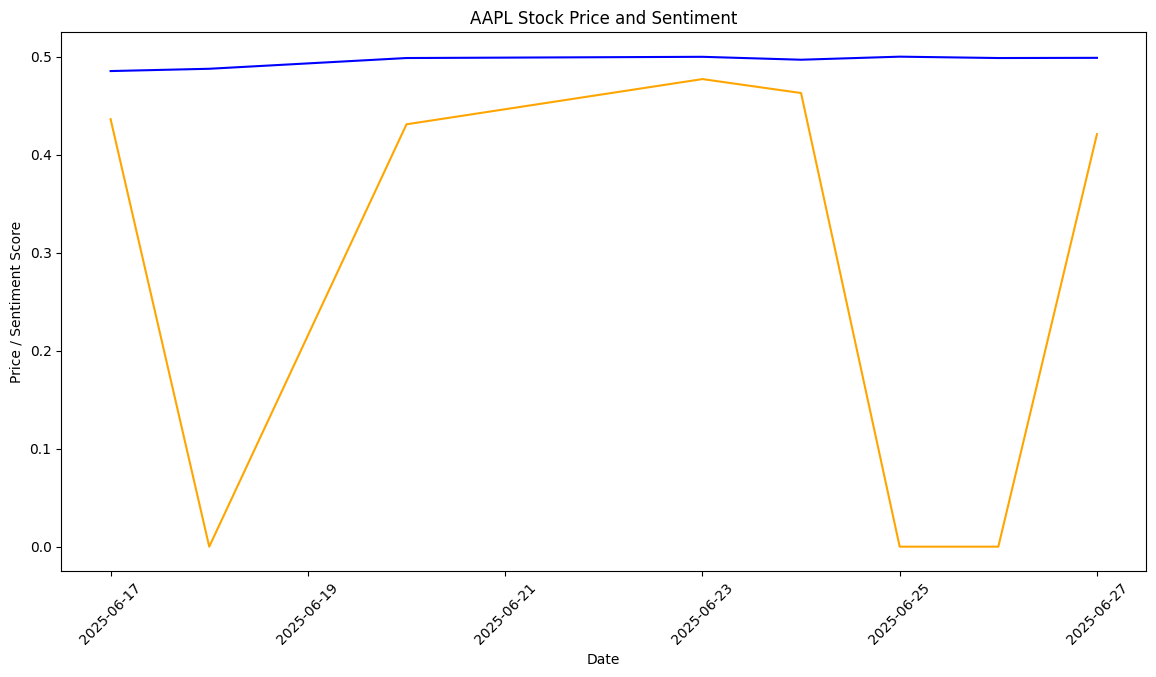

In [13]:
#plot AAPL stock price with sentiment
import matplotlib.pyplot as plt
import pandas as pd
def plot_stock_with_sentiment(df: pd.DataFrame, ticker: str):
    df_ticker = df[df['ticker'] == ticker]
    plt.figure(figsize=(14, 7))
    #scale the close price for better visualization
    df_ticker['close'] = df_ticker['close'] / df_ticker['close'].max() * 0.5
    plt.plot(df_ticker['date'], df_ticker['close'], label='Close Price', color='blue')
    plt.plot(df_ticker['date'], df_ticker['reddit_sentiment_score'], label='Reddit Sentiment', color='orange')
    plt.xticks(rotation=45)
    plt.title(f"{ticker} Stock Price and Sentiment")
    plt.xlabel("Date")
    plt.ylabel("Price / Sentiment Score")
    plt.show()

df = pd.read_csv("../data/processed/recent_data_with_sentiment.csv", parse_dates=['date'])

plot_stock_with_sentiment(df, 'AAPL')